Copyright **`(c)`** 2025 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [41]:
from itertools import combinations
import numpy as np
import os
import time
import matplotlib.pyplot as plt


## Simple Test Problem

In [14]:
CITIES = [
    "Rome",
    "Milan",
    "Naples",
    "Turin",
    "Palermo",
    "Genoa",
    "Bologna",
    "Florence",
    "Bari",
    "Catania",
    "Venice",
    "Verona",
    "Messina",
    "Padua",
    "Trieste",
    "Taranto",
    "Brescia",
    "Prato",
    "Parma",
    "Modena",
]
test_problem = np.load('lab2/test_problem.npy')

## Common tests

In [15]:
problem = np.load('lab2/problem_g_20.npy')

In [16]:
# Negative values?
np.any(problem < 0)

False

If True, edge costs can be negative. A Hamiltonian cycle still exists (we forbid self-loops and repeats), but algorithms assuming non-negativity (some approximations, certain penalties) must be adapted.

In [17]:
# Diagonal is all zero?
np.allclose(np.diag(problem), 0.0)

True

In TSP the cost i -> i is never used (we don’t allow staying in a city). Non-zero diagonal won’t affect cycle cost if our evaluator never uses diagonal entries.

In [18]:
# Symmetric matrix?
np.allclose(problem, problem.T)

True

If True: STSP (undirected/symmetric).
If False: ATSP (directed/asymmetric).

In [19]:
# Triangular inequality
all(
    problem[x, y] <= problem[x, z] + problem[z, y]
    for x, y, z in list(combinations(range(problem.shape[0]), 3))
)

True

If always True and symmetric & non-negative → metric STSP (strong approximation guarantees; 2-opt is potent, Christofides exists).

If asymmetric but inequality holds -> directed metric ATSP.

If violated → non-metric (heuristics may still work, but some performance guarantees and neighborhood assumptions don’t hold).

## I. The Problem

## problem_g_50
- Negatives: No
- Diagonal all zero: Yes
- Symmetric: True (so STSP)
- Triangle inequality: True
- Directed metric STSP 

## problem_r1_50
- Negatives: No
- Diagonal all zero: Yes
- Symmetric: False (ATSP)
- Triangle inequality: False
- Asymmetric non-metric.

## problem_r2_50
- Negatives: Yes
- Diagonal all zero: No
- Symmetric: False (ATSP)
- Triangle inequality: False
- Asymmetric non-metric with negatives.

## II. Define the cost and problem validation

In [20]:
def tour_cost(tour: np.ndarray, problem: np.ndarray) -> float:
    tour = np.asarray(tour, dtype=int)
    nxt = tour[(np.arange(len(tour)) + 1) % len(tour)]
    # D[tour, next] looks up the distance for each step.
    return float(np.sum(problem[tour,nxt])) 

# The "tour_cost" function also makes sure that the tours start, and end in the same city by using The modulo operator (%) 
# Which makes the tour "circular" by automatically handling the wrap-around from the last city back to the first.

This is our Evaluation or Fitness Function. The key logic lies in the  nxt = tour[(np.arange(len(tour)) + 1) % len(tour)] line. It builds a "next city" array that automatically handles the wrap-around from the last city back to the first. The np.sum(D[tour, nxt]) then sums up the cost of every single edge in the cycle.

In [21]:
def is_hamiltonian_cycle(tour: np.ndarray, n: int) -> bool:
    tour = np.asarray(tour, dtype=int)
    return (
            # Is the tour a 1D list?
            tour.ndim == 1 
            # Does it have the right number of cities?
            and len(tour) == n 
            # Are all city numbers valid (e.g., no negative numbers or numbers > n)?
            and np.all((0 <= tour) & (tour < n)) 
            # Does it visit every city exactly once?
            # np.unique(tour) removes duplicates.
            # If the original tour had duplicates, the length of the
            # unique set will be *less* than n, and this check will fail.
            and (len(np.unique(tour)) == n))

This is our Validation function. It's a sanity check to make sure our crossover and mutation operators aren't creating broken tours (e.g., with duplicate cities). It checks for four conditions: is it a list, is it the right length, are all city IDs valid, and are all cities unique?

## III. Problem Definition & Possible Solutions

**Representation (Genotype)**: A tour. The most natural way is a permutation of N cities, like [0, 4, 1, 3, 2] 
**Fitness Function**: tour_cost. Our goal is to minimize this. 
**"Tweak" (Mutation/Neighborhood Operator)**: We can't just flip a bit. To change a tour, we need permutation-specific operators:
- **Swap Mutation**: Pick two random cities in the tour and swap their positions.
- **Insert Mutation**: Pick a random city and move it to a random new position.
- **Inversion Mutation (or 2-Opt)**: Pick two random edges in the tour and reverse the entire segment between them . This is apparently a very powerful "tweak" for TSP.

## First Improvement Hill Climber (Default, Baseline)
I want to start off with a very basic hill climber to get some baselines and improve upon them. I am expecting the hill climber to work well on problem_g instances, but not the others.

In [12]:
def hill_climber(problem: np.ndarray, num_evaluations: int):
    num_cities = problem.shape[0]
    
    # Initialize
    current_tour = np.random.permutation(num_cities)
    current_cost = tour_cost(current_tour, problem)
    
    best_tour = current_tour
    best_cost = current_cost
    
    # Store history
    cost_history = [current_cost]
    
    # Main Loop
    for _ in range(num_evaluations):
        # Tour swap (swapping two random cities in the tour)
        num_cities = len(current_tour)
        i , j = np.random.randint(0, num_cities, size=2)
        while i == j:
            j = np.random.randint(0, num_cities)
        new_tour = current_tour.copy()
        new_tour[i], new_tour[j] = new_tour[j], new_tour[i]
        
        new_cost = tour_cost(new_tour, problem)
        
        # First Improvement
        if new_cost < current_cost:
            current_tour = new_tour
            current_cost = new_cost
            
            if new_cost < best_cost:
                best_tour = new_tour
                best_cost = new_cost
        cost_history.append(current_cost)
    return best_tour, best_cost, cost_history    

In [40]:
results_hill_climb = []

In [285]:
problem = np.load('lab2/problem_g_100.npy')
hill_tour, hill_cost, hill_history = hill_climber(problem, 200000)

In [286]:
print("\n--- Results ---")
print(f"Hill Climber Final cost: {hill_cost:.2f}")
print(f"Is tour valid? {is_hamiltonian_cycle(hill_tour, problem.shape[0])}")


--- Results ---
Hill Climber Final cost: 6546.75
Is tour valid? True


In [ ]:
results_hill_climb.append(["r2_1000", hill_cost, is_hamiltonian_cycle(hill_tour, problem.shape[0])])

In [287]:
results_hill_climb

[['g_10', 1497.6636482252907, True],
 ['g_20', 1755.514677083005, True],
 ['g_50', 3677.2804493803023, True],
 ['g_100', 6609.6429791872615, True],
 ['g_200', 12879.281708040082, True],
 ['g_500', 40570.59087288073, True],
 ['g_1000', 69213.3342511231, True],
 ['r1_10', 229.8871779701194, True],
 ['r1_20', 493.3897148608525, True],
 ['r1_50', 828.9520994510987, True],
 ['r1_100', 1423.2499875600856, True],
 ['r1_200', 2569.1709340080065, True],
 ['r1_500', 5423.965487684343, True],
 ['r1_1000', 12422.824279735396, True],
 ['r2_10', -332.9918479950065, True],
 ['r2_20', -706.5487251787936, True],
 ['r2_50', -1939.3149023483315, True],
 ['r2_50', -4018.149217372032, True],
 ['r2_200', -8376.784074887024, True],
 ['r2_500', -21395.256848751495, True],
 ['r2_500', -41938.03105765204, True]]

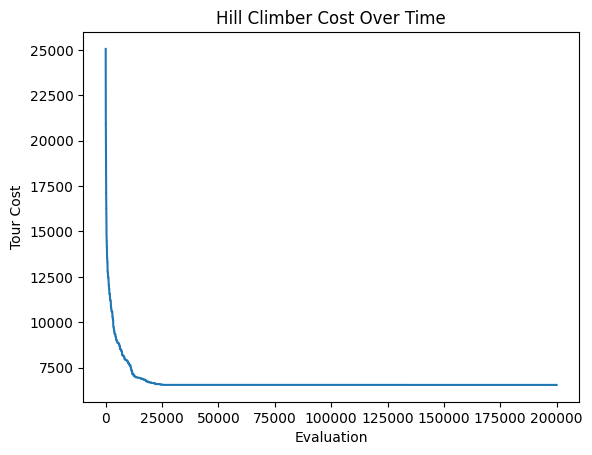

In [288]:
import matplotlib.pyplot as plt
plt.plot(hill_history)
plt.title("Hill Climber Cost Over Time")
plt.xlabel("Evaluation")
plt.ylabel("Tour Cost")
plt.show()

## Genetic Algorithm

In [22]:
def create_random_tour(num_cities: int) -> np.ndarray:
    return np.random.permutation(num_cities)

Initialization function. It just uses np.random.permutation to give us a valid, shuffled tour. 

In [23]:
def tweak_tour_swap(tour: np.ndarray) -> np.ndarray:
    "Creates a new tour by swapping two random cities."
    new_tour = tour.copy()
    num_cities = len(tour)
    
    i,j = np.random.randint(0, num_cities, size=2)
    while i == j:
        j = np.random.randint(0, num_cities)
        
    new_tour[i], new_tour[j] = new_tour[j], new_tour[i]
    return new_tour


Tweak/Mutation operator. It's the simplest one. It just picks two random cities in the tour and swaps their positions. Its job is to add a little bit of new genetic material and prevent the GA from getting stuck on one solution too early

In [37]:
import random

def tweak_tour_insert(tour):
    # Ensure we are working with a Python list to use .pop() and .insert()
    new_tour = list(tour)
    
    # Select a city to move (and remove it)
    city_index = random.randrange(len(new_tour))
    city_to_move = new_tour.pop(city_index)
    
    # Select a new position to insert it. The range should be len + 1
    # to allow insertion at the very end of the tour.
    new_position = random.randrange(len(new_tour) + 1)
    new_tour.insert(new_position, city_to_move)
    
    return new_tour


In [25]:
def tournament_selection(
    population: list, 
    k: int = 3
):
    # We select by their *indices* to avoid copying large tours
    indices = np.random.randint(0, len(population), size=k)
    
    best_contestant_idx = indices[0]
    best_cost = population[best_contestant_idx][1] 
    
    for i in indices[1:]:
        cost = population[i][1]
        if cost < best_cost: 
            best_cost = cost
            best_contestant_idx = i
            
    return population[best_contestant_idx][0]

Parent Selection operator. To pick one parent, it grabs k (e.g., 3) random solutions from the current population. It compares their costs (which we conveniently stored) and returns the best one (lowest cost) from that small tournament. It's fast, simple, and works perfectly even with negative costs (unlike roulette wheel).

In [26]:
def order_crossover(parent1: np.ndarray, parent2: np.ndarray) -> np.ndarray:
    num_cities = len(parent1)
    
    start, end = np.sort(np.random.randint(0, num_cities, size=2))
    
    # Ensure the slice has at least one element (and is not the whole array)
    while start == end:
         start, end = np.sort(np.random.randint(0, num_cities, size=2))

    child = np.full(num_cities, -1, dtype=int) # (placeholder)
    child[start:end+1] = parent1[start:end+1]
    
    slice_cities = set(parent1[start:end+1])
    shopping_list = [city for city in parent2 if city not in slice_cities]
    
    shopping_idx = 0
    num_filled = 0
    
    # Start filling from the position *after* the slice
    child_idx = (end + 1) % num_cities 
    
    while num_filled < len(shopping_list):
        if child[child_idx] == -1:
            child[child_idx] = shopping_list[shopping_idx]
            shopping_idx += 1
            num_filled += 1
        
        # Move to the next spot in the child, wrapping around
        child_idx = (child_idx + 1) % num_cities
            
    return child

Crossover (Recombination)
1. It takes two parent tours.
2. It selects a random slice (e.g., cities at index 3, 4 5) from parent1 and copies it directly into the new child.
3. It then scans parent2 and makes a "shopping list" of all cities not in that slice, keeping them in the order they appeared in parent2.
4. Finally, it fills the empty child slots after the slice (wrapping around to the beginning) using the items from the "shopping list."

It's guaranteed to create a valid Hamiltonian cycle that inherits the slice from P1 and the relative order of the other cities from P2.

In [32]:
import random

def partially_mapped_crossover(parent1, parent2):
    """
    Implements a robust version of Partially Mapped Crossover (PMX).
    
    It creates offspring by choosing a subsequence from one parent and preserving
    the order and position of as many cities as possible from the other parent,
    correctly handling mapping conflicts.
    """
    size = len(parent1)
    # Make copies to avoid modifying the original parents
    p1, p2 = parent1[:], parent2[:]
    
    # Initialize children with placeholders
    child1, child2 = [-1] * size, [-1] * size

    # 1. Choose a random subsequence
    start, end = sorted(random.sample(range(size), 2))

    # 2. Copy the subsequence from parents to children
    child1[start:end] = p1[start:end]
    child2[start:end] = p2[start:end]

    # 3. Fill the remaining positions in the children
    for i in list(range(start)) + list(range(end, size)):
        # --- Fill child1 ---
        # Take the city from parent2
        city_from_p2 = p2[i]
        
        # If this city is not already in child1, we can place it
        if city_from_p2 not in child1:
            child1[i] = city_from_p2
        else:
            # If the city is already in child1, we have a conflict.
            # We need to find which city from parent1 was displaced by it.
            # We follow the mapping chain until we find a free city.
            current_city = city_from_p2
            while current_city in child1:
                # Find the index of the current city in the child's segment
                idx_in_child_segment = child1.index(current_city)
                # Find the city from parent2 that is at the same position
                current_city = p2[idx_in_child_segment]
            child1[i] = current_city

        # --- Fill child2 (symmetric logic) ---
        city_from_p1 = p1[i]
        if city_from_p1 not in child2:
            child2[i] = city_from_p1
        else:
            current_city = city_from_p1
            while current_city in child2:
                idx_in_child_segment = child2.index(current_city)
                current_city = p1[idx_in_child_segment]
            child2[i] = current_city
            
    return child1, child2


We Implement Partially Mapped Crossover (PMX).

It creates offspring by choosing a subsequence from one parent and preserving the order and position of as many cities as possible from the other parent.

In [95]:

import random

class AdaptiveOperatorManager:
    def __init__(self, crossover_operators: list, mutation_operators: list):
        # Operators are the function objects themselves
        self.crossover_ops = {op.__name__: {'op': op, 'score': 1, 'uses': 0} for op in crossover_operators}
        self.mutation_ops = {op.__name__: {'op': op, 'score': 1, 'uses': 0} for op in mutation_operators}

    def select_crossover(self,epsilon=0.20):
        if random.random() < epsilon:
            selected_op_name = random.choice(list(self.crossover_ops.keys()))
        else:
            op_names = list(self.crossover_ops.keys())
            weights = [self.crossover_ops[name]['score'] for name in op_names]
            selected_op_name = random.choices(op_names, weights=weights, k=1)[0]
        self.crossover_ops[selected_op_name]['uses'] += 1
        return self.crossover_ops[selected_op_name]['op']

    def select_mutation(self):
        op_names = list(self.mutation_ops.keys())
        weights = [self.mutation_ops[name]['score'] for name in op_names]
        selected_op_name = random.choices(op_names, weights=weights, k=1)[0]
        self.mutation_ops[selected_op_name]['uses'] += 1
        return self.mutation_ops[selected_op_name]['op']

    def reward_crossover(self, op_func, child_cost, parent1_cost, parent2_cost):
        # Success if child is better than the average of parents
        if child_cost < (parent1_cost + parent2_cost) / 2.0:
            op_name = op_func.__name__
            self.crossover_ops[op_name]['score'] += 1

    def reward_mutation(self, op_func, child_cost, original_cost):
        if child_cost < original_cost:
            op_name = op_func.__name__
            self.mutation_ops[op_name]['score'] += 1
            
    def reset_scores(self):
        for op_name in self.crossover_ops:
            self.crossover_ops[op_name]['score'] = 1
            self.crossover_ops[op_name]['uses'] = 0
        for op_name in self.mutation_ops:
            self.mutation_ops[op_name]['score'] = 1
            self.mutation_ops[op_name]['uses'] = 0

    def get_status(self):
        """Returns a string with the current usage stats of operators."""
        status = []
        for name, data in self.crossover_ops.items():
            status.append(f"{name}: {data['uses']} uses")
        for name, data in self.mutation_ops.items():
            status.append(f"{name}: {data['uses']} uses")
        return " | ".join(status)


In [54]:
def calculate_adaptive_mutation_rate(population, min_rate=0.05, max_rate=0.5):
    """
    Calculates an adaptive mutation rate based on population diversity.
    
    Args:
        population: The current population, where each item is [tour, cost].
        min_rate: The minimum possible mutation rate.
        max_rate: The maximum possible mutation rate.
        
    Returns:
        An adjusted mutation rate.
    """
    costs = [ind[1] for ind in population]
    best_cost = costs[0] # Assumes population is sorted
    avg_cost = sum(costs) / len(costs)
    
    # Avoid division by zero if all costs are the same
    if avg_cost == 0 or best_cost == avg_cost:
        return max_rate # Population has converged, jolt it with high mutation

    # Normalize the difference between average and best cost.
    # A value closer to 0 means low diversity; closer to 1 means high diversity.
    diversity_metric = (avg_cost - best_cost) / avg_cost
    
    # We want an inverse relationship: low diversity -> high mutation rate.
    # Clamp the metric to be safe.
    diversity_metric = max(0, min(diversity_metric, 1.0))
    
    # Linearly interpolate the mutation rate.
    # When diversity is 0, rate is max_rate. When diversity is 1, rate is min_rate.
    mutation_rate = max_rate - (diversity_metric * (max_rate - min_rate))
    
    return mutation_rate


In [105]:
class DescriptiveLogger:
    """A logger to provide clean, descriptive output for the GA run."""
    def __init__(self, update_window):
        self.stagnation_counter = 0
        self.last_best_cost = float('inf')
        self.update_window = update_window

    def log_generation(self, gen, best_cost, current_elitism, elitism_changed):
        """Call this once per generation to handle all logging."""
        gen_num = gen + 1

        if best_cost < self.last_best_cost:
            if self.stagnation_counter > 0:
                print(f"  └─> Improvement after {self.stagnation_counter} stagnant generations.")
            
            improvement_percent = ((self.last_best_cost - best_cost) / self.last_best_cost) * 100
            print(f"✅ Gen {gen_num:<4} | New Best Cost: {best_cost:<10.2f} ({improvement_percent:.2f}%)", end="")
            
            self.stagnation_counter = 0
            self.last_best_cost = best_cost
        else:
            self.stagnation_counter += 1
        
        if elitism_changed:
            print(f" | Elitism: {current_elitism}")
        elif best_cost < self.last_best_cost:
            print() # Newline after improvement if elitism didn't change

    def log_status_update(self, gen_num, population, op_manager, mutation_rate):
        """Prints a periodic summary of the algorithm's state."""
        costs = [ind[1] for ind in population]
        avg_cost = sum(costs) / len(costs)
        
        print("\n" + "─" * 20 + f" STATUS @ GEN {gen_num} " + "─" * 20)
        print(f"  Best Cost: {costs[0]:.2f} | Avg Cost: {avg_cost:.2f}")
        print(f" Mutation Rate: {mutation_rate:.3f}")
        print(f"  Operator Usage (last window): {op_manager.get_status()}")
        print("─" * 58 + "\n")
        
    def log_initial(self, best_cost):
        print(f"🚀 Gen 0    | Initial Best Cost: {best_cost:.2f}")
        self.last_best_cost = best_cost

    def log_final(self, gen, best_cost):
        print("\n" + "🏁" + "="*20 + " FINAL RESULTS " + "="*20 + "🏁")
        print(f"Finished at Gen {gen}. Final Best Cost: {best_cost:.2f}")


In [107]:
import numpy as np
import random

def genetic_algorithm(
    problem_matrix: np.ndarray,
    population_size: int,
    num_generations: int,
    crossover_rate: float,
    update_window: int = 100 
):
    """
    Solves the TSP using a genetic algorithm with selectable operators.

    Args:
        problem_matrix: The distance matrix for the cities.
        population_size: The number of individuals in the population.
        num_generations: The number of generations to evolve.
        crossover_rate: The probability of performing crossover.
        mutation_rate: The probability of performing mutation.
        elitism_size: The number of best individuals to carry over to the next generation.
        problem_type: The type of problem ('metric' or 'asymmetric') to determine
                      which genetic operators to use.
    """
    num_cities = problem_matrix.shape[0]
    
    crossover_operators = [order_crossover, partially_mapped_crossover]
    mutation_operators = [tweak_tour_swap, tweak_tour_insert]
    
    base_elitism_size = 1
    max_elitism_size = 5
    current_elitism_size = base_elitism_size
 
    op_manager = AdaptiveOperatorManager(crossover_operators,mutation_operators)

    # Initialize population
    population = []
    for _ in range(population_size):
        tour = create_random_tour(num_cities)
        cost = tour_cost(tour, problem_matrix)
        population.append([tour, cost])
        
    population.sort(key=lambda x: x[1])
    
    best_tour = population[0][0]
    best_cost = population[0][1]
    cost_history = [best_cost]
    
    logger = DescriptiveLogger(update_window=100) # Status update every 100 gens
    logger.log_initial(best_cost)

    # MAIN LOOP: Evolve for N generations
    for gen in range(num_generations):
        
        if gen > 0 and gen % update_window == 0:
            op_manager.reset_scores()
        new_generation = []
        
        # ELITISM
        if current_elitism_size > 0:
            new_generation.extend(population[:current_elitism_size])
            
        # BREEDING
        while len(new_generation) < population_size:
            
            # Select Parents
            parent1= tournament_selection(population, k=3)
            parent2 = tournament_selection(population, k=3)
            
            cost1 = tour_cost(parent1,problem_matrix)
            cost2 = tour_cost(parent2,problem_matrix)
            
            # Crossover (or just copy)
            if random.random() < crossover_rate:
                # PMX returns two children, we'll just use the first one for simplicity
                crossover_fn = op_manager.select_crossover()
                result = crossover_fn(parent1, parent2)
                child = result[0] if isinstance(result, tuple) else result
                child_cost = tour_cost(child, problem_matrix)
                op_manager.reward_crossover(crossover_fn, child_cost, cost1, cost2)
            else:
                child = parent1[:] # Just clone Parent 1
            
            # Mutate 
            original_cost = tour_cost(child, problem_matrix)
            mutation_rate = calculate_adaptive_mutation_rate(population,min_rate=0.02, max_rate=0.30)
            if random.random() < mutation_rate:
                mutation_fn = op_manager.select_mutation()
                child = mutation_fn(child)
                new_cost = tour_cost(child, problem_matrix)
                op_manager.reward_mutation(mutation_fn, new_cost, original_cost)
            # Add new child to the next generation
            new_generation.append([child, tour_cost(child, problem_matrix)])
            
        
        previous_best_cost = best_cost
        population = new_generation
        
        # EVALUATE: Sort the new population and find the new best
        population.sort(key=lambda x: x[1])
        best_cost = population[0][1]
        
        elitism_changed = False
        if best_cost < previous_best_cost:
            best_tour = population[0][0]
            best_cost = population[0][1]
            # Added a check to avoid printing for every minor improvement
            current_elitism_size = min(current_elitism_size + 1, max_elitism_size)
            elitism_changed = True
        elif best_cost == previous_best_cost:
            # ADAPT ELITISM: Stagnated. Decrease elitism for next generation.
            if current_elitism_size > base_elitism_size:
                current_elitism_size -= 1
                elitism_changed = True
        cost_history.append(best_cost)
        
        logger.log_generation(gen,best_cost, current_elitism_size, elitism_changed)
        if (gen + 1) % update_window == 0:
            logger.log_status_update(gen + 1, population, op_manager, mutation_rate)
            op_manager.reset_scores()
    
    return best_tour, best_cost, cost_history


1. Initialization: It starts by creating a population of population_size (e.g., 100) random tours and calculating the cost for each one. It sorts this initial population and saves the best one as our starting best_tour.

2. Generational Loop: It then loops for num_generations. In each generation, it builds a new_generation from scratch.

3. Elitism: The first thing it does is copy the elitism_size (e.g., 2) best tours from the old population directly into the new one. It guarantees that we never lose our best-found solution.

4. Breeding Loop: It then fills the rest of the new_generation by:

5. Selecting two parents using tournament_selection.

    An experiment that I did here was to create an asymmetric selection pressure. 
    
    The parent 1 was chosen with high selection pressure. It's very likely one of the elite tours from my population. They are an exploitation parent.

    The parent 2 was chosen with standard pressure. They are likely to be a good tour, but has a higher chance of being a more average of diverse tour. They are an exploration parent.

    (This idea worked well for metric problem_g instances, had to drop it for r1 and r2. I needed to increase exploration to keep the search jumping around.)

    - Crossing them over using order_crossover (if np.random.rand() < crossover_rate).

    - Mutating the resulting child (if np.random.rand() < mutation_rate).

    - Calculating the new child's cost and adding it to the new_generation.

    Replacement: Once the new_generation is full, it completely replaces the old population. This is a "generational replacement" model.

    Logging: It sorts the new (and now current) population, finds its best member, and checks if it's a new "all-time best." It records the best cost for this generation in the cost_history.

    Finish: After all generations are done, it returns the best tour and cost it ever found during the entire run.

## Problem G - 500

In [82]:
problem = np.load("lab2/problem_g_500.npy")

In [84]:
POP_SIZE = 300 # How many tours in our pop
GENERATIONS = 1000 # Generations
PC = 0.9 # Crossover Rate


In [85]:
start_time = time.time()
final_tour, final_cost, _ = genetic_algorithm(problem, POP_SIZE, GENERATIONS, PC,update_window=100)
end_time = time.time()

🚀 Gen 0    | Initial Best Cost: 122865.56
✅ Gen 1    | New Best Cost: 120458.78  (1.96%) | Elitism: 2
✅ Gen 2    | New Best Cost: 119367.82  (0.91%) | Elitism: 3
✅ Gen 3    | New Best Cost: 118704.48  (0.56%) | Elitism: 4
✅ Gen 4    | New Best Cost: 118035.53  (0.56%) | Elitism: 5
✅ Gen 5    | New Best Cost: 116851.82  (1.00%) | Elitism: 5
✅ Gen 6    | New Best Cost: 116626.22  (0.19%) | Elitism: 5
 | Elitism: 4
  └─> Improvement after 1 stagnant generations.
✅ Gen 8    | New Best Cost: 115728.96  (0.77%) | Elitism: 5
✅ Gen 9    | New Best Cost: 114064.81  (1.44%) | Elitism: 5
 | Elitism: 4
 | Elitism: 3
 | Elitism: 2
  └─> Improvement after 3 stagnant generations.
✅ Gen 13   | New Best Cost: 113259.42  (0.71%) | Elitism: 3
✅ Gen 14   | New Best Cost: 112637.50  (0.55%) | Elitism: 4
 | Elitism: 3
  └─> Improvement after 1 stagnant generations.
✅ Gen 16   | New Best Cost: 111706.94  (0.83%) | Elitism: 4
✅ Gen 17   | New Best Cost: 111654.60  (0.05%) | Elitism: 5
 | Elitism: 4
  └─> Impr

In [415]:
print("\n--- Problem G-500 Final Results ---")
print(f"Time: {end_time - start_time:.2f} seconds")
print(f"Final cost: {final_cost:.2f}")
print(f"Is tour valid? {is_hamiltonian_cycle(final_tour, problem.shape[0])}")


--- Problem G-500 Final Results ---
Time: 303.50 seconds
Final cost: 14736.36
Is tour valid? True


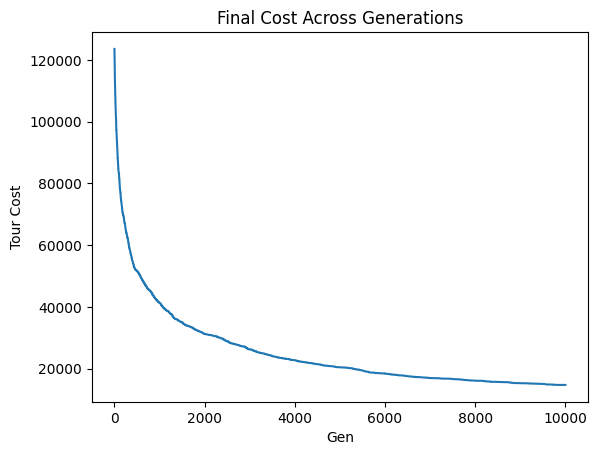

In [414]:
plt.plot(_)
plt.title("Final Cost Across Generations")
plt.xlabel("Gen")
plt.ylabel("Tour Cost")
plt.show()

## Problem R1-200

In [69]:
problem = np.load("lab2/problem_r1_200.npy")

In [73]:
POP_SIZE = 300 
GENERATIONS = 10000 
PC = 1


In [77]:
start_time = time.time()
final_tour, final_cost, _ = genetic_algorithm(problem, POP_SIZE, GENERATIONS,PC,update_window=100)
end_time = time.time()

🚀 Gen 0    | Initial Best Cost: 9306.92
✅ Gen 1    | New Best Cost: 9196.47    (1.19%) | Elitism: 2
✅ Gen 2    | New Best Cost: 9129.24    (0.73%) | Elitism: 3
✅ Gen 3    | New Best Cost: 9018.80    (1.21%) | Elitism: 4
✅ Gen 4    | New Best Cost: 8827.63    (2.12%) | Elitism: 5
✅ Gen 5    | New Best Cost: 8636.82    (2.16%) | Elitism: 5
 | Elitism: 4
  └─> Improvement after 1 stagnant generations.
✅ Gen 7    | New Best Cost: 8596.25    (0.47%) | Elitism: 5
✅ Gen 8    | New Best Cost: 8437.60    (1.85%) | Elitism: 5
 | Elitism: 4
 | Elitism: 3
  └─> Improvement after 2 stagnant generations.
✅ Gen 11   | New Best Cost: 8353.15    (1.00%) | Elitism: 4
 | Elitism: 3
  └─> Improvement after 1 stagnant generations.
✅ Gen 13   | New Best Cost: 8259.39    (1.12%) | Elitism: 4
✅ Gen 14   | New Best Cost: 8224.75    (0.42%) | Elitism: 5
✅ Gen 15   | New Best Cost: 8154.88    (0.85%) | Elitism: 5
✅ Gen 16   | New Best Cost: 8079.14    (0.93%) | Elitism: 5
✅ Gen 17   | New Best Cost: 8052.03    (

In [81]:
print("\n--- Problem R1-200 Final Results ---")
print(f"Time: {end_time - start_time:.2f} seconds")
print(f"Final cost: {final_cost:.2f}")
print(f"Is tour valid? {is_hamiltonian_cycle(final_tour, problem.shape[0])}")


--- Problem R1-200 Final Results ---
Time: 251.87 seconds
Final cost: 3124.05
Is tour valid? True


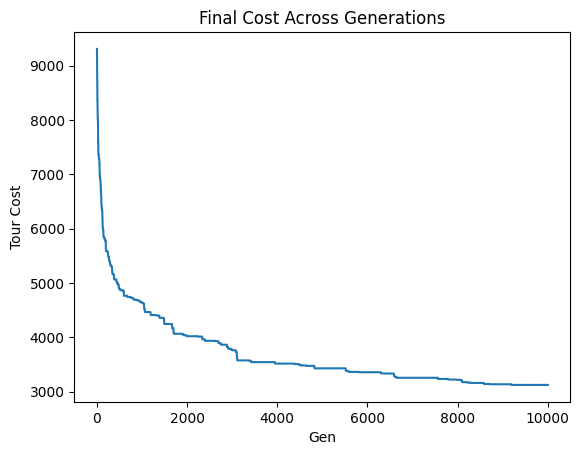

In [80]:
plt.plot(_)
plt.title("Final Cost Across Generations")
plt.xlabel("Gen")
plt.ylabel("Tour Cost")
plt.show()

## Problem R2-200

In [96]:
problem = np.load("lab2/problem_r2_200.npy")

In [98]:
POP_SIZE = 200 
GENERATIONS = 10000 
PC = 0.9 


In [99]:
start_time = time.time()
final_tour, final_cost, _ = genetic_algorithm(problem, POP_SIZE, GENERATIONS, PC,update_window=100)
end_time = time.time()

🚀 Gen 0    | Initial Best Cost: -1125.99
✅ Gen 1    | New Best Cost: -1391.13   (-23.55%) | Elitism: 2
✅ Gen 2    | New Best Cost: -1629.77   (-17.15%) | Elitism: 3
 | Elitism: 2
  └─> Improvement after 1 stagnant generations.
✅ Gen 4    | New Best Cost: -1874.65   (-15.03%) | Elitism: 3
 | Elitism: 2
  └─> Improvement after 1 stagnant generations.
✅ Gen 6    | New Best Cost: -2122.43   (-13.22%) | Elitism: 3
✅ Gen 7    | New Best Cost: -2141.79   (-0.91%) | Elitism: 4
✅ Gen 8    | New Best Cost: -2154.13   (-0.58%) | Elitism: 5
 | Elitism: 4
 | Elitism: 3
 | Elitism: 2
  └─> Improvement after 3 stagnant generations.
✅ Gen 12   | New Best Cost: -2457.69   (-14.09%) | Elitism: 3
✅ Gen 13   | New Best Cost: -2520.78   (-2.57%) | Elitism: 4
 | Elitism: 3
  └─> Improvement after 1 stagnant generations.
✅ Gen 15   | New Best Cost: -2640.40   (-4.75%) | Elitism: 4
✅ Gen 16   | New Best Cost: -3028.45   (-14.70%) | Elitism: 5
 | Elitism: 4
  └─> Improvement after 1 stagnant generations.
✅ Gen

In [100]:
print("\n--- Problem R2-200 Final Results ---")
print(f"Time: {end_time - start_time:.2f} seconds")
print(f"Final cost: {final_cost:.2f}")
print(f"Is tour valid? {is_hamiltonian_cycle(final_tour, problem.shape[0])}")


--- Problem R2-200 Final Results ---
Time: 368.36 seconds
Final cost: -7932.39
Is tour valid? True


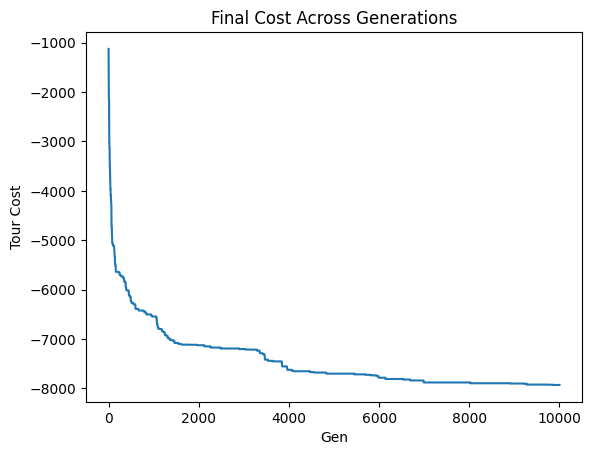

In [101]:
plt.plot(_)
plt.title("Final Cost Across Generations")
plt.xlabel("Gen")
plt.ylabel("Tour Cost")
plt.show()

## Main

In [91]:
PROBLEM_PATH = 'lab2/'
SAVE_DIR = 'lab_results'
SEED = 42
PROBLEMS = ['problem_g_200', 'problem_r1_200', 'problem_r2_200']

# Config for metric problems (e.g., problem_g)
g_config = {
    'population': 300,
    'generations': 5000,
    'crossover_rate': 1,
}

# Config for non-metric/asymmetric problems (e.g., r1, r2)
r_config = {
    'population': 300,
    'generations': 5000,
    'crossover_rate': 1,
}

In [92]:
def plot_and_save_results(
    history: list, 
    problem_name: str, 
    save_dir: str
):
    print(f"  Generating and saving plot for {problem_name}...")
    
    plt.figure(figsize=(10, 6))
    plt.plot(history)
    plt.title(f"GA Convergence for {problem_name}")
    plt.xlabel("Generation")
    plt.ylabel("Best Tour Cost")
    plt.grid(True)
    
    # Create the filename
    save_path = os.path.join(save_dir, f"{problem_name}_convergence.png")
    
    try:
        plt.savefig(save_path)
        print(f"  Plot saved to: {save_path}")
    except Exception as e:
        print(f"  Error saving plot: {e}")
        
    plt.close() # Close the figure to free up memory

In [93]:
def run_tsp_experiments(
    problems_to_run: list,
    problem_path: str,
    save_dir: str,
    metric_config: dict,
    non_metric_config: dict,
    seed: int
):
    """
    Runs a series of TSP experiments using a genetic algorithm.

    It iterates through a list of problems, selects a configuration based on the
    problem type, runs the solver, and saves the results and convergence plots.

    Args:
        problems_to_run: A list of problem names (without extension).
        problem_path: The directory where problem .npy files are stored.
        save_dir: The directory where results and plots will be saved.
        metric_config: A dictionary of GA parameters for metric problems.
        non_metric_config: A dictionary of GA parameters for non-metric problems.
        seed: A random seed for reproducibility.
    """
    os.makedirs(save_dir, exist_ok=True)
    all_results = {}

    for name in problems_to_run:
        problem_file = os.path.join(problem_path, f"{name}.npy")
        print(f"\n--- Running Problem: {name} ---")
        
        np.random.seed(seed)
        random.seed(seed) # Also seed the 'random' module if used in operators

        # Select configuration and operator strategy based on problem name
        if name.startswith('problem_g'):
            config = metric_config
        else:
            config = non_metric_config
            
        problem_data = np.load(problem_file)
        start_time = time.time()
        
        final_tour, final_cost, cost_history = genetic_algorithm(
            problem_matrix=problem_data,
            population_size=config['population'],
            num_generations=config['generations'],
            crossover_rate=config['crossover_rate'],
            update_window=100
        )
        end_time = time.time()
        run_time = end_time - start_time
        
        is_valid = is_hamiltonian_cycle(final_tour, problem_data.shape[0])
        
        print("\n  --- Results ---")
        print(f"  Run Time: {run_time:.2f} seconds")
        print(f"  Final Cost: {final_cost:.2f}")
        print(f"  Is tour valid? {is_valid}")
        
        # Store results
        all_results[name] = {
            'cost': final_cost,
            'time': run_time,
            'valid': is_valid
        }
        
        plot_and_save_results(cost_history, name, save_dir)
        
    return all_results

In [108]:

final_results = run_tsp_experiments(
     problems_to_run=PROBLEMS,
     problem_path=PROBLEM_PATH,
     save_dir=SAVE_DIR,
     metric_config=g_config,
     non_metric_config=r_config,
     seed=SEED)

print("\n--- Experiment Summary ---")
for name, results in final_results.items():
    print(f"  {name}: Cost={results['cost']:.2f}, Time={results['time']:.2f}s")




--- Running Problem: problem_g_200 ---
🚀 Gen 0    | Initial Best Cost: 48672.11
✅ Gen 1    | New Best Cost: 47943.29   (1.50%) | Elitism: 2
✅ Gen 2    | New Best Cost: 47933.05   (0.02%) | Elitism: 3
✅ Gen 3    | New Best Cost: 47520.36   (0.86%) | Elitism: 4
✅ Gen 4    | New Best Cost: 46954.27   (1.19%) | Elitism: 5
✅ Gen 5    | New Best Cost: 45419.66   (3.27%) | Elitism: 5
 | Elitism: 4
 | Elitism: 3
  └─> Improvement after 2 stagnant generations.
✅ Gen 8    | New Best Cost: 45350.39   (0.15%) | Elitism: 4
✅ Gen 9    | New Best Cost: 44544.38   (1.78%) | Elitism: 5
✅ Gen 10   | New Best Cost: 43546.67   (2.24%) | Elitism: 5
✅ Gen 11   | New Best Cost: 43331.18   (0.49%) | Elitism: 5
✅ Gen 12   | New Best Cost: 43247.06   (0.19%) | Elitism: 5
✅ Gen 13   | New Best Cost: 42958.47   (0.67%) | Elitism: 5
✅ Gen 14   | New Best Cost: 42753.37   (0.48%) | Elitism: 5
 | Elitism: 4
  └─> Improvement after 1 stagnant generations.
✅ Gen 16   | New Best Cost: 41688.52   (2.49%) | Elitism: 5
✅